## Preprocesamiento del cubo
Se usa la librería Pillow para sacar los valores RGB que se encuentran en cada celda de las imágenes del cubo extraidas de [este sitio web](https://rubikscu.be/).

54


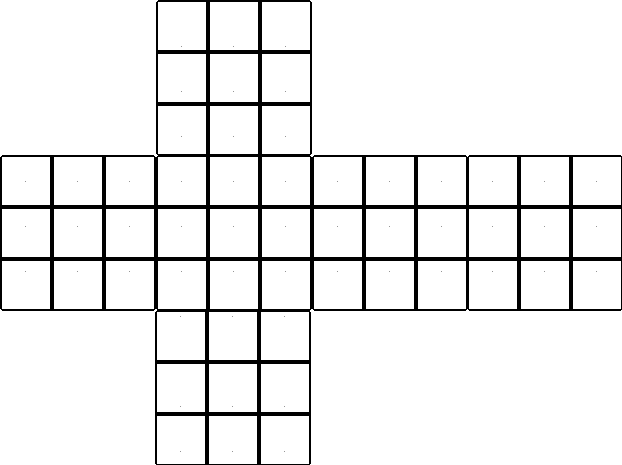

In [33]:
from PIL import Image, ImageOps
import numpy as np
import copy
import re

i1 = Image.open('Images\cleared_cube.png')
i1_m = np.array(i1) # Matriz de imagen a color
i2 = ImageOps.grayscale(i1)
i2_m = np.array(i2) # Matriz de imagen a escala de grises

# Colorea todo lo que no sea borde a blanco y los bordes a negro
for i in range(len(i2_m)):
    for j in range(len(i2_m[i])):
        if i2_m[i][j] > 50:
            i2_m[i][j] = 255
        else:
            i2_m[i][j] = 0

edges = [[(i, j) for j in range(len(i2_m[i])) if i2_m[i][j] == 0] for i in range(len(i2_m))] # Posiciones de los bordes

# Obtención de los margenes del cubo de la imagen
top, bottom, left, right = len(i2_m), 0, len(i2_m[0]), 0
for i in edges:
    for j in i:
        if j[0] < top: top = j[0]
        if j[0] > bottom: bottom = j[0]
        if j[1] < left: left = j[1]
        if j[1] > right: right = j[1]

# Recorte de las imagenes
i2_m = i2_m[top:bottom, left:right]
i1_m = i1_m[top:bottom, left:right]

# Extracción del color de cada celda del cubo
count = 0
c = 0
colors = [] # Los colores aparecen en orden de izquierda a derecha y luego de arriba a abajo
for i in range(1, len(i2_m), 45):
    for j in range(len(i2_m[i])):
        if i2_m[i][j] == 255:
            count += 1
        elif count < 55 and count > 5:
            i2_m[i][j-25] = 150 # Para revisar los pixeles tomados
            colors.append(i1_m[i][j-25])
            count = 0
            c += 1
        else:
            count = 0
    count = 0

print(len(colors)) # Para ver que el número de colores sea correcto
i2 = Image.fromarray(i2_m) # Solo para ver los puntos de donde se sacó el color
i2

## Estructura del cubo

In [34]:
class cube:
    """
    Clase cubo que contiene 6 objetos _cube_face que corresponden a las caras del cubo.
    """
    class _cube_face:
        """
        Clase representativa de la cara de un cubo que contiene 9 celdas.
        """

        def __init__(self):
            """
            Constructor de la cara, con 1 array bidimensional 3x3 y 4 atributos usados para referenciar las caras vecinas.

            Attributes:
                matrix (numpy.ndarray)
                up (Nonetype): Vecino encima.
                down (Nonetype): Vecino debajo.
                left (Nonetype): Vecino a la izquierda.
                right (Nonetype): Vecino a la derecha.
            """
            self.matrix = np.zeros((3, 3))
            self.weight = np.zeros((3, 3))
            self.up = None
            self.down = None
            self.left = None
            self.right = None

        def links(self, up, down, left, right):
            """
            Función que enlaza las caras vecinas de una respectiva cara.

            Args:
                up (_cube_face): Vecino encima.
                down (_cube_face): Vecino debajo.
                left (_cube_face): Vecino a la izquierda.
                right (_cube_face): Vecino a la derecha.

            Attributes:
                up (_cube_face): Vecino encima.
                down (_cube_face): Vecino debajo.
                left (_cube_face): Vecino a la izquierda.
                right (_cube_face): Vecino a la derecha.
            """
            self.up = up
            self.down = down
            self.left = left
            self.right = right

        def clockwise(self):
            """
            Rotación a favor del reloj a partir de una cara.
            """
            # Rotación de la matriz de la cara.
            self.matrix = np.rot90(self.matrix, axes=(1, 0))

            # Rotación de las celdas afectadas de los vecinos.
            temp = copy.copy(self.right.matrix[:,0][::-1]) # copy.copy es para evitar se asigne una referencia. El valor es invertido.
            self.right.matrix[:,[0]] = np.array([self.up.matrix[2]]).T
            self.up.matrix[2] = self.left.matrix[:,2][::-1] # El valor es invertido.
            self.left.matrix[:,[2]] = np.array([self.down.matrix[0]]).T
            self.down.matrix[0] = temp

        def counterclockwise(self):
            """
            Rotación contrarreloj a partir de una cara
            """

            # Rotación de la matriz de la cara.
            self.matrix = np.rot90(self.matrix, axes=(0, 1))

            # Rotación de las celdas afectadas de los vecinos.
            temp = copy.copy(self.left.matrix[:,2])
            self.left.matrix[:,[2]] = np.array([self.up.matrix[2][::-1]]).T
            self.up.matrix[2] = self.right.matrix[:,0]
            self.right.matrix[:,[0]] = np.array([self.down.matrix[0][::-1]]).T
            self.down.matrix[0] = temp

    def __init__(self):
        """
        Constructor del cubo, genera las 6 caras y las enlaza con sus respectivas vecinas.

        Attributes:
            F (_cube_face): Cara frontal (front).
            R (_cube_face): Cara derecha (right).
            B (_cube_face): Cara trasera (back).
            L (_cube_face): Cara izquierda (left).
            U (_cube_face): Cara superior (up).
            D (_cube_face): Cara inferior (down).
        """
        self.F = self._cube_face()
        self.R = self._cube_face()
        self.B = self._cube_face()
        self.L = self._cube_face()
        self.U = self._cube_face()
        self.D = self._cube_face()
        self.faces = [self.U, self.L, self.F, self.R, self.B, self.D] # Esto sirve de ayuda para llenar las matrices
        
        self.F.links(self.U, self.D, self.L, self.R)
        self.R.links(self.U, self.D, self.F, self.B)
        self.B.links(self.U, self.D, self.R, self.L)
        self.L.links(self.U, self.D, self.B, self.F)
        self.U.links(self.B, self.F, self.R, self.L)
        self.D.links(self.F, self.B, self.R, self.L)

    def show(self):
        """
        Muestra en consola el estado actual del cubo.
        """
        # Las caras unidas horizontalmente.
        middle_line = (self.L.matrix, self.F.matrix, self.R.matrix, self.B.matrix)
        # Las caras concatenadas en una sola matriz.
        middle = np.concatenate(middle_line, axis=1)

        # Formateando el texto.
        text = '\t  ' + f' {self.U.matrix}'.replace('\n', '\n\t  ')
        text += '\n\t   ' + '-------\n'
        for row in middle:
            for i in range(len(row)):
                text += f'{np.format_float_positional(row[i], precision=0)} '
                if ((i+1)%3 == 0 and (i+1 != len(row))):
                    text += f'| '
            text += '\n'
        text += '\t   -------'
        text += '\n\t  ' + f' {self.D.matrix}'.replace('\n', '\n\t  ')
        text = re.sub('\[|\]', '', text)
        print(text)

    def weights(self):
        pass

## Llenado de las matrices del cubo

In [57]:
rubik = cube()
unique_col = np.unique(colors, axis=0)
col_nums = tuple(enumerate(unique_col))

# Llenado cara superior
nums = []
for i in colors[:9]:
    for count, item in col_nums:
        if (i == item).all():
            nums.append(count)

index = 0
for i in range(len(rubik.U.matrix)):
    for j in range(len(rubik.U.matrix[i])):
        rubik.U.matrix[i][j] = nums[index]
        index += 1

# Llenado caras centrales
# middle_line = rubik.faces[1:-1]

# Llenado cara inferior
nums = []
for i in colors[-9:]:
    for count, item in col_nums:
        if (i == item).all():
            nums.append(count)

index = 0
for i in range(len(rubik.D.matrix)):
    for j in range(len(rubik.D.matrix[i])):
        rubik.D.matrix[i][j] = nums[index]
        index += 1

rubik.show()

	   5. 5. 5.
	   5. 5. 5.
	   5. 5. 5.
	   -------
0. 0. 0. | 0. 0. 0. | 0. 0. 0. | 0. 0. 0. 
0. 0. 0. | 0. 0. 0. | 0. 0. 0. | 0. 0. 0. 
0. 0. 0. | 0. 0. 0. | 0. 0. 0. | 0. 0. 0. 
	   -------
	   4. 4. 4.
	   4. 4. 4.
	   4. 4. 4.


In [201]:
a = cube()
a.F.matrix = np.array([[j+1+3*i for j in range(len(a.U.matrix))] for i in range(len(a.U.matrix))], dtype = np.float32)
a.U.matrix = np.array([[j+1+3*i for j in range(len(a.U.matrix))] for i in range(len(a.U.matrix))], dtype = np.float32)


a.show()
a.F.counterclockwise()
print('_'*50)
a.show()
a.F.counterclockwise()
print('_'*50)
a.show()
a.F.counterclockwise()
print('_'*50)
a.show()
a.F.counterclockwise()
print('_'*50)


	   1. 2. 3.
	   4. 5. 6.
	   7. 8. 9.
	   -------
0. 0. 0. | 1. 2. 3. | 0. 0. 0. | 0. 0. 0. 
0. 0. 0. | 4. 5. 6. | 0. 0. 0. | 0. 0. 0. 
0. 0. 0. | 7. 8. 9. | 0. 0. 0. | 0. 0. 0. 
	   -------
	   0. 0. 0.
	   0. 0. 0.
	   0. 0. 0.
__________________________________________________
	   1. 2. 3.
	   4. 5. 6.
	   0. 0. 0.
	   -------
0. 0. 9. | 3. 6. 9. | 0. 0. 0. | 0. 0. 0. 
0. 0. 8. | 2. 5. 8. | 0. 0. 0. | 0. 0. 0. 
0. 0. 7. | 1. 4. 7. | 0. 0. 0. | 0. 0. 0. 
	   -------
	   0. 0. 0.
	   0. 0. 0.
	   0. 0. 0.
__________________________________________________
	   1. 2. 3.
	   4. 5. 6.
	   0. 0. 0.
	   -------
0. 0. 0. | 9. 8. 7. | 0. 0. 0. | 0. 0. 0. 
0. 0. 0. | 6. 5. 4. | 0. 0. 0. | 0. 0. 0. 
0. 0. 0. | 3. 2. 1. | 0. 0. 0. | 0. 0. 0. 
	   -------
	   9. 8. 7.
	   0. 0. 0.
	   0. 0. 0.
__________________________________________________
	   1. 2. 3.
	   4. 5. 6.
	   0. 0. 0.
	   -------
0. 0. 0. | 7. 4. 1. | 7. 0. 0. | 0. 0. 0. 
0. 0. 0. | 8. 5. 2. | 8. 0. 0. | 0. 0. 0. 
0. 0. 0. | 9. 6. 